# Stanford CME 241 (Winter 2026) - Assignment 3

**Due: Friday, February 27 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Yusuke
- Evan
- Yuming

## Imports

In [3]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from typing import Iterable, Iterator, Mapping, TypeVar, Callable, Sequence, Tuple, Dict
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess
from rl.chapter10.prediction_utils import compare_td_and_mc
from dataclasses import dataclass
from rl.markov_decision_process import MarkovDecisionProcess, NonTerminal, State, Terminal
from rl.distribution import Distribution, Constant, SampledDistribution
X = TypeVar('X')
S = TypeVar('S')

## Question 1: Milk Vendor Optimization Problem (Led by Yusuke)

You are a milk vendor and your task is to bring to your store a supply (denoted $S \in \mathbb{R}$) of milk volume in the morning that will give you the best profits. You know that the demand for milk throughout the course of the day is a probability distribution function $f$ (for mathematical convenience, assume people can buy milk in volumes that are real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous variable with a probability density function). 

For every extra gallon of milk you carry at the end of the day (supply $S$ exceeds random demand $x$), you incur a cost of $h$ (effectively the wasteful purchases amounting to the difference between your purchase price and the end-of-day discount disposal price since you are not allowed to sell the same milk the next day). For every gallon of milk that a customer demands that you don’t carry (random demand $x$ exceeds supply $S$), you incur a cost of $p$ (effectively the missed sales revenue amounting to the difference between your sales price and purchase price). 

Your task is to identify the optimal supply $S$ that minimizes your **Expected Cost** $g(S)$, given by:

$$
g_1(S) = \mathbb{E}[\max(x - S, 0)] = \int_{S}^{\infty} (x - S) \cdot f(x) \, dx
$$

$$
g_2(S) = \mathbb{E}[\max(S - x, 0)] = \int_{-\infty}^{S} (S - x) \cdot f(x) \, dx
$$

$$
g(S) = p \cdot g_1(S) + h \cdot g_2(S)
$$

---

### Part (A): Analytical Optimization

1. **Derive the first-order condition (FOC)** for minimizing the expected cost $g(S)$.
2. **Solve the FOC** to express the optimal supply $S^*$ in terms of the given parameters: $p$, $h$, and the demand distribution $f(x)$. (*Hint*: Pay attention to the balance between the costs of overstocking and understocking)

3. **Interpretation**: Provide an interpretation of the condition you derived. What does the balance between $p$ and $h$ imply about the optimal supply $S^*$?

---

### Part (B): Special Case Analysis

1. Consider the case where the demand $x$ follows an **exponential distribution** with parameter $\lambda > 0$. That is, $f(x) = \lambda e^{-\lambda x}$ for $x \geq 0$.
    - Derive an explicit expression for the optimal supply $S^*$.
    
2. Consider the case where the demand $x$ follows a **normal distribution** with mean $\mu$ and variance $\sigma^2$, i.e., $x \sim \mathcal{N}(\mu, \sigma^2)$. 
    - Set up the integral for $g(S)$ and describe how it relates to the **cumulative distribution function (CDF)** of the normal distribution.
    - Provide an interpretation of how changes in $\mu$ and $\sigma$ influence the optimal $S^*$. 

---

### Part (C): Framing as a Financial Options Problem

1. Frame the milk vendor’s problem as a **portfolio of call and put options**:
    - Identify the analog of the “strike price” and “underlying asset.”
    - Explain which part of the cost function $g_1(S)$ or $g_2(S)$ corresponds to a call option and which part to a put option.
    - What do $p$ and $h$ represent in this options framework?

2. Explain how this framing could be used to derive the optimal supply $S^*$ if solved using financial engineering concepts.

---

### Part (D): Numerical Solution and Simulation

1. **Numerical Solution**: Write a Python function that numerically estimates the optimal $S^*$ using an iterative search or numerical optimization method. 

2. **Simulation**: Generate random samples of milk demand from an exponential distribution and simulate the total costs for different values of $S$. Plot the costs against $S$ and visually identify the optimal $S$.

### Part (A) Answer

#### 1. Derive the FOC

Let $F(S)=\int_{-\infty}^S f(x)\,dx$ denote the CDF.
Differentiate $g_1$ using Leibniz's rule:
\begin{align*}
g_1'(S)
&=\frac{d}{dS}\int_S^\infty x f(x)\,dx - \frac{d}{dS}\left(S\int_S^\infty f(x)\,dx\right) \\
&=-Sf(S)-\left(\int_S^\infty f(x)\,dx - Sf(S)\right) \\
&=-\int_S^\infty f(x)\,dx \\
&=-(1-F(S)).
\end{align*}

Differentiate $g_2$:
\begin{align*}
g_2'(S)
&=\frac{d}{dS} \left(S\int_{-\infty}^S f(x)\,dx\right) - \frac{d}{dS} \int_{-\infty}^S x f(x)\,dx, \\
&=\left(\int_{-\infty}^S f(x)\,dx + Sf(S)\right) - Sf(S) \\
&=\int_{-\infty}^S f(x)\,dx \\
&=F(S).
\end{align*}

Therefore
\begin{align*}
g'(S)
&=p\,g_1'(S)+h\,g_2'(S) \\
&=-p+pF(S)+hF(S) \\
&=-p+(p+h)F(S).
\end{align*}

The FOC $g'(S^*)=0$ is $-p+(p+h)F(S^*)=0$.


#### 2. Solve the FOC

Rearranging:
$$
F(S^*)=\frac{p}{p+h}.
$$
Hence the optimal supply is the corresponding quantile:
$$
S^* = F^{-1}\!\left(\frac{p}{p+h}\right).
$$


#### 3. Interpretation

The condition suggests to choose $S^*$ so that the probability we run out of stock is $\frac{h}{p+h}$.
If $p$, the understock cost, is high relative to $h$, the overstock cost, then $\frac{p}{p+h}$ is high, so $S^*$ is high. It is more profitable to stock more to avoid expensive stockouts. In the opposite case, $S^*$ decreases to avoid costly leftovers.

### Part (B) Answer

#### 1. Exponential distribution

For an exponential distribution, the cumulative distribution function is $F(x)=1-e^{-\lambda x}$.
Applying the result above, we solve
\begin{align*}
1 - e^{-\lambda S^*} &= \frac{p}{p+h} \\
\Longrightarrow \qquad S^* &= -\frac{1}{\lambda}\log\left(\frac{h}{p+h}\right)
= \frac{1}{\lambda}\log\left(\frac{p+h}{h}\right).
\end{align*}

#### 2. Normal distribution

Here
$$
f(x)=\frac{1}{\sigma\sqrt{2\pi}}
\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right),
\qquad
F(x)=\Phi\left(\frac{x-\mu}{\sigma}\right),
$$
where $\Phi$ is the standard normal CDF.
The expected cost is
$$
g(S)=p\int_S^\infty (x-S)f(x)\,dx
+h\int_{-\infty}^S (S-x)f(x)\,dx.
$$
From Part (A), we have that the derivative of this depends (an affine transformation) on the CDF $F(S)$.
Using Part (A),
$$
S^*=\mu+\sigma\,\Phi^{-1}\left(\frac{p}{p+h}\right).
$$

**Interpretation.**  
The optimal supply is the $\frac{p}{p+h}$-quantile of the normal distribution. Increasing $\mu$ increases $S^*$ linearly one-for-one, while increasing $\sigma$ moves $S^*$ further from $\mu$ in the direction determined by the cost ratio.

### Part (C) Answer

#### 1. Options portfolio

We interpret the analogs:
- **Underlying asset:** the random demand $x$.
- **Strike price:** the chosen supply level $S$.

Then
- $(x-S)^+$ is the payoff of a **call option** on $x$ with strike $S$, so $g_1(S)$ is the expected call payoff.
- $(S-x)^+$ is that of the corresponding **put option**, so $g_2(S)$ is the expected put payoff.

The total expected cost is therefore
$$
g(S)=p\,\mathbb E[(x-S)^+] + h\,\mathbb E[(S-x)^+] = \mathbb E[p (x - S)^+ + h (S - x)^+],
$$
i.e., a portfolio of $p$ calls and $h$ puts with common strike $S$.
In this interpretation, $p$ is the weight on the call component or the number of calls in the portfolio, representing the marginal cost of understocking.
$h$ is the corresponding coefficient for the put option.

#### 2. Solution

Changing $S$ shifts the strike of both options.   When $S$ increases slightly:

- The call payoff decreases only in states where $x>S$, i.e. when the call finishes in the money.
- The put payoff increases only in states where $x<S$, i.e. when the put finishes in the money.

Therefore, the marginal effect of changing the strike is governed purely by probabilities:
- The call component is weighted by $\mathbb P(x>S)$.
- The put component is weighted by $\mathbb P(x<S)$.

At the optimal strike $S^*$, these weighted in-the-money probabilities must balance:
$$
p\,\mathbb P(x>S^*) = h\,\mathbb P(x<S^*).
$$

Since $\mathbb P(x<S)=F(S)$, this gives
$$
F(S^*)=\frac{p}{p+h},
\qquad
S^*=F^{-1}\!\left(\frac{p}{p+h}\right).
$$

Financially, the optimal supply is the strike that makes the call-heavy and put-heavy parts of the portfolio equally influential in expectation.


### Part (D) Answer

In [5]:
'''
fill in the code below, and then run the code in the next cell for the simulation
'''
from scipy.integrate import quad

# simulation parameters
p = 5  # Cost of understocking (per unit)
h = 2  # Cost of overstocking (per unit)
lambda_param = 1.0  # Parameter for exponential distribution

# Probability density function for demand
def demand_pdf(x):
    return lambda_param * np.exp(-lambda_param * x) if x >= 0 else 0.0

# Cumulative distribution function for demand
def demand_cdf(x):
    # explicit formula for CDF of exponential distribution
    # return 1.0 - np.exp(-lambda_param * x) if x >= 0 else 0.0
    
    # general CDF using numerical integration based on demand_pdf
    value, _ = quad(demand_pdf, -np.inf, x)
    return value

# Expected cost function g(S)
def expected_cost(S):
    # g1(S): Understocking cost
    g1, _ = quad(lambda x: (x - S) * demand_pdf(x), S, np.inf)
    
    # g2(S): Overstocking cost (integral using CDF)
    g2, _ = quad(lambda x: (S - x) * demand_pdf(x), -np.inf, S)
    
    return p * g1 + h * g2

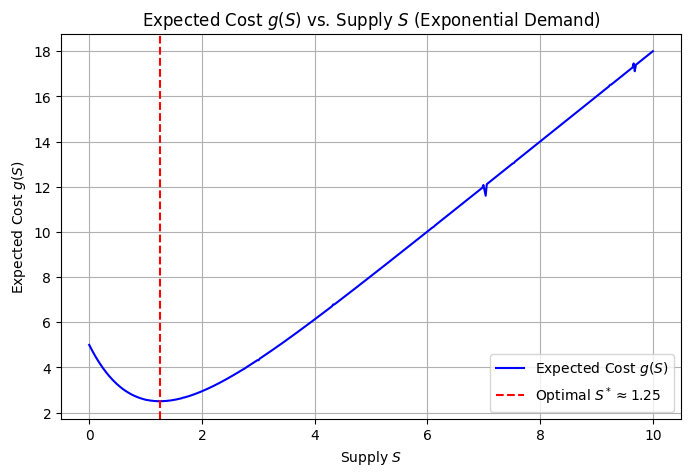

1.2528000434439797

In [6]:
result = minimize_scalar(expected_cost, bounds=(0, 10), method='bounded')
optimal_S = result.x

# Simulation of costs
S_values = np.linspace(0, 10, 500)
costs = [expected_cost(S) for S in S_values]

# Plotting the costs against S
plt.figure(figsize=(8, 5))
plt.plot(S_values, costs, label="Expected Cost $g(S)$", color='blue')
plt.axvline(optimal_S, color='red', linestyle='--', label=f"Optimal $S^* \\approx {optimal_S:.2f}$")
plt.xlabel("Supply $S$")
plt.ylabel("Expected Cost $g(S)$")
plt.title("Expected Cost $g(S)$ vs. Supply $S$ (Exponential Demand)")
plt.legend()
plt.grid(True)
plt.show()

optimal_S

#### Simulation

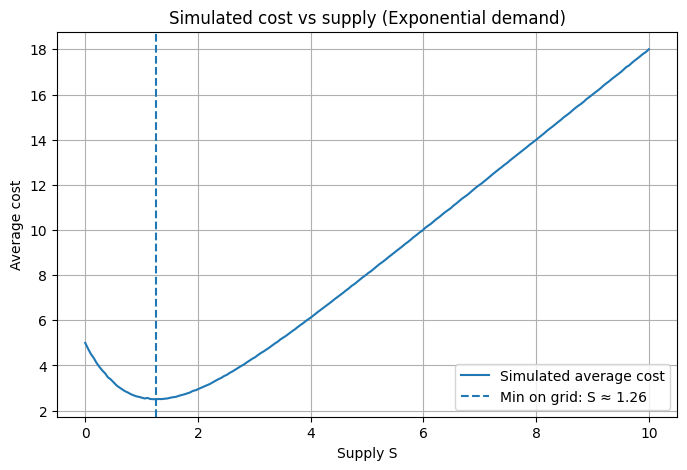

In [29]:
N = 100_000
S_values = np.linspace(0, 10, 200)

def simulated_cost_exponential(S: float) -> float:
    x = np.random.exponential(scale=1.0 / lambda_param, size=N)
    return np.mean(p * np.maximum(x - S, 0.0) + h * np.maximum(S - x, 0.0))

costs = np.array([simulated_cost_exponential(S) for S in S_values])

idx = int(np.argmin(costs))
S_min = float(S_values[idx])

plt.figure(figsize=(8, 5))
plt.plot(S_values, costs, label="Simulated average cost")
plt.axvline(S_min, linestyle="--", label=f"Min on grid: S ≈ {S_min:.2f}")
plt.xlabel("Supply S")
plt.ylabel("Average cost")
plt.title("Simulated cost vs supply (Exponential demand)")
plt.grid(True)
plt.legend()
plt.show()

## Question 2: Car Sales (Led By: Evan)

You must sell your car within a finite window of $N$ days. At the beginning of each day $t \in \{1, \dots, N\}$, you receive a single offer $X_t$ from a dealership, where $\{X_t\}$ are i.i.d. draws from a known continuous distribution $Q$ supported on $[m, M]$, with $0 < m < M$.

After observing $X_t$, you must immediately choose whether to **accept** or **reject** the offer:

- If you **accept** on day $t$, you sell the car immediately and receive payoff $X_t$. The process then terminates.
- If you **reject** on day $t < N$, you keep the car, pay a parking cost $c \ge 0$ at the end of that day, and proceed to day $t+1$.
- On day $N$, you must accept the offer (i.e., rejecting is not allowed).

Your objective is to maximize the expected **net payoff**, defined as the sale price minus the total parking costs paid before the sale.

---

### Part (A): MDP Modeling

Model this problem as a finite-horizon **Markov Decision Process (MDP)**. Clearly specify:

1. **States**
2. **Actions**
3. **Rewards**
4. **State-transition probabilities**
5. **Discount factor** (use $\gamma = 1$)

Also state whether this MDP is finite- or infinite-horizon, episodic or continuing, and whether it is time-homogeneous.

---

### Part (B): Structure of the Optimal Policy

Let $V_t$ denote the optimal value function when there are $t$ days remaining (before observing the offer).

1. Write down the Bellman recursion for $V_t$.
2. Show that the optimal policy is a **time-dependent threshold policy**: that is, there exists a reservation price $r_t$ such that it is optimal to accept an offer $x$ if and only if $x \ge r_t$.
3. Express the threshold $r_t$ in terms of $V_{t-1}$ and $c$.

(You may leave expectations with respect to $Q$ written in integral or expectation form. A closed-form solution for general $Q$ is not required.)

---

### Part (C): Special Case (No Integrals)

Now consider the special case where $c = 0$ and $Q = \text{Uniform}[m, M]$.

1. Write the recursion for $V_t$ explicitly.
2. Provide the optimal policy in as closed-form a way as possible. Your policy may depend on recursively defined coefficients, but your final expressions should contain **no integrals**.


### Part (A) Answer

1. States: $s_t = (t,x_t)$ where t is the current day and $x_t$ is the offer on day $t$
2. Actions: accept or reject offer, on day $t=T$ you can only accept.
3. Rewards: accepted offer amount
4. State-Transition Probs: 
$$p(s_{terminal}\ |\ (t,x), Accept) = 1$$
$$p((t+1,x_{t+1})\ |\ (t,x), Reject) = q(x_{t+1})$$
$$@ \ t\ =\ T,\ p(s_{terminal}\ |\ (T,x), Accept) = 1$$
5. Doscount Factor: $\gamma = 1$

This MDP is finite horizon, episodic, and not time-homogeneous.

### Part (B) Answer

1. Bellman Recursion for $V_t$: $V_t = \mathbb{E}[max(X, V_{t-1}-c)] $ with $V_0 = 0$

2 \& 3. Show optimal policy is a time-dependent threshold policy:

if we fix there to be t days left, then after observing the offer on day t, we can either accept(get x) or reject that offer (remaining reward is $V_{t-1}-c$ ). The distribution is continuos, so no tie-compliactions arise, so there exists a reservation price such that its optimal to accet iff $x \geq r_t$
$$r_t = V_{t-1}-c$$



### Part (C) Answer


Now consider $c = 0$ and $Q = \text{Uniform}[m, M]$.

#### 1. Recursion for $V_t$

With $t$ days remaining, the optimal value is

$$
V_t = \mathbb{E}[\max(x, V_{t-1})], \quad x \sim \text{Uniform}[m,M].
$$

Evaluating the expectation gives

$$
V_t =
\frac{V_{t-1}(V_{t-1}-m) + \frac{1}{2}(M^2 - V_{t-1}^2)}{M-m}.
$$

which simplifies to

$$
V_t =
\frac{V_{t-1}^2 - 2mV_{t-1} + M^2}{2(M-m)}.
$$

with boundary condition

$$
V_1 = \frac{m+M}{2}.
$$

#### 2. Optimal Policy

The optimal policy is a threshold rule

$$
r_t = V_{t-1}.
$$

Accept the offer $x$ if

$$
x \ge V_{t-1}.
$$

Otherwise reject and continue.



## Question 3: Constrained Consumption (Led By: Yusuke)

Consider the following discrete-time MDP for constrained consumption. At $t = 0$, the agent is given a finite amount $x_0 \in \mathbb{R}^+$ of a resource. In each time period, the agent can choose to consume any amount of the resource, with the consumption denoted as $c \in [0, x]$ where $x$ is the amount of the resource remaining at the start of the time period. This consumption results in a reduction of the resource at the start of the next time period:  

$$x' = x - c.$$

Consuming a quantity $c$ of the resource provides a utility of consumption equal to $U(c)$, and we adopt the **CRRA utility function**:  
$$
U(c) = \frac{c^{1 - \gamma}}{1 - \gamma}, \quad (\gamma > 0, \gamma \neq 1)
$$

Our goal is to maximize the aggregate discounted utility of consumption until the resource is completely consumed. We assume a discount factor of $\beta \in (0, 1)$ when discounting the utility of consumption over any single time period. Assume parameters are such that the value function is finite.

We model this as a **discrete-time, continuous-state-space, continuous-action-space, stationary, deterministic MDP**, and so our goal is to solve for the **Optimal Value Function** and associated **Optimal Policy**, which will give us the optimal consumption trajectory of the resource. Since this is a stationary MDP, the **State** is simply the amount $x$ of the resource remaining at the start of a time period. The **Action** is the consumption quantity $c$ in that time period. The **Reward** for a time period is $U(c)$ when the consumption in that time period is $c$. The discount factor over each single time period is $\beta$.

We assume that the **Optimal Policy** is given by:  
$$
c^* = \theta^* \cdot x \quad \text{for some } \theta^* \in [0, 1].
$$

---

### Part (A): Closed-form Expression for $V_\theta(x)$

Our first step is to consider a fixed deterministic policy, given by:  
$$c = \theta \cdot x \quad \text{for some fixed } \theta \in [0, 1].$$
Derive a closed-form expression for the **Value Function** $V_\theta(x)$ for a fixed deterministic policy, given by $c = \theta \cdot x$. Specifically, you need to express $V_\theta(x)$ in terms of $\beta$, $\gamma$, $\theta$, and $x$.

---

### Part (B): Solving for $\theta^*$

Use this closed-form expression for $V_\theta(x)$ to solve for the $\theta^*$ which maximizes $V_\theta(x)$ (thus fetching us the **Optimal Policy** given by $c^* = \theta^* \cdot x$).

---

### Part (C): Expression for $V^*(x)$

Use this expression for $\theta^*$ to obtain an expression for the **Optimal Value Function** $V^*(x)$ in terms of only $\beta$, $\gamma$, and $x$.

---

### Part (D): Validation of the Bellman Equation

Validate that the **Optimal Policy** (derived in part B) and **Optimal Value Function** (derived in part C) satisfy the **Bellman Optimality Equation**.

### Part (A) Answer

Under the fixed policy, the state evolves deterministically as
$$
x_{t+1}=x_t-c_t=(1-\theta)x_t,
$$
so $x_t=(1-\theta)^t x$. Hence consumption for $x_0 = x$ is
$$
c_t=\theta x_t=\theta(1-\theta)^t x.
$$
The value under this policy is
$$
\begin{align*}
V_\theta(x)&=\sum_{t=0}^\infty \beta^t U(c_t) =\sum_{t=0}^\infty \beta^t \frac{\left(\theta(1-\theta)^t x\right)^{1-\gamma}}{1-\gamma} \\
&=\frac{(\theta x)^{1-\gamma}}{1-\gamma}
\sum_{t=0}^\infty \left(\beta(1-\theta)^{1-\gamma}\right)^t \\
&= \frac{(\theta x)^{1-\gamma}}{(1-\gamma)\left( 1-\beta(1-\theta)^{1-\gamma} \right)},
\end{align*}
$$
since $\beta \in (0, 1)$ implies $|\beta(1-\theta)^{1-\gamma}|<1$.

### Part (B) Answer

From Part (A), we are to maximize
$$
V_\theta(x)=\frac{x^{1-\gamma}}{1-\gamma}\cdot
\frac{\theta^{1-\gamma}}{1-\beta(1-\theta)^{1-\gamma}}.
$$
Since the first term does not depend on $\theta$, maximize
$$
f(\theta)=\frac{\theta^{1-\gamma}}{1-\beta(1-\theta)^{1-\gamma}},\qquad \theta\in[0,1].
$$
The first-order condition is
$$
\begin{align*}
f'(\theta)=0
&\quad\Longleftrightarrow\quad
\left(1-\beta(1-\theta)^{1-\gamma}\right)(1-\gamma)\theta^{-\gamma}
=\theta^{1-\gamma}\beta(1-\gamma)(1-\theta)^{-\gamma} \\
&\quad\Longleftrightarrow\quad
1-\beta(1-\theta)^{1-\gamma}
=\beta\theta(1-\theta)^{-\gamma} \\
&\quad\Longleftrightarrow\quad
1=\beta(1-\theta)^{-\gamma}
\quad\Longleftrightarrow\quad
(1-\theta)^\gamma=\beta,
\end{align*}
$$
so $\theta^*=1-\beta^{1/\gamma}$.

### Part (C) Answer

Plug $\theta^*$ into $V_\theta(x)$. Note that
$$
1-\beta(1-\theta^*)^{1-\gamma}=1-\beta\left(\beta^{1/\gamma}\right)^{1-\gamma}
=1-\beta^{1/\gamma}.
$$
Therefore
$$
V^*(x)=V_{\theta^*}(x)
=\frac{x^{1-\gamma}}{1-\gamma}\cdot
\frac{\left(1-\beta^{1/\gamma}\right)^{1-\gamma}}{1-\beta^{1/\gamma}}
=\frac{x^{1-\gamma}}{1-\gamma}\left(1-\beta^{1/\gamma}\right)^{-\gamma}.
$$

### Part (D) Answer

We need to check the Bellman Equation:
$$
V^*(x)=\max_{c\in[0,x]}\left\{U(c)+\beta V^*(x-c)\right\}.
$$

Substituting $V^*$ from above, we have that the RHS is
$$
\max_{c\in[0,x]}\frac{1}{1-\gamma}
\left(c^{1-\gamma}
+\beta\left(1-\beta^{1/\gamma}\right)^{-\gamma}(x-c)^{1-\gamma}\right).
$$
Let the expression to be maximized be denoted $\phi(c)$. To maximize, the first-order condition is
$$
\begin{align*}
\phi'(c)=0
&\quad\Longleftrightarrow\quad
c^{-\gamma}
=\beta\left(1-\beta^{1/\gamma}\right)^{-\gamma}(x-c)^{-\gamma} \\
&\quad\Longleftrightarrow\quad
c
=\left(\beta^{-1/\gamma} - 1\right) (x-c) \\
&\quad\Longleftrightarrow\quad
c=\left(1-\beta^{1/\gamma}\right)x.
\end{align*}
$$

Evaluating at this maximizing choice of $c$,
$$
\begin{align*}
U(c^*)+\beta V^*(x-c^*)
&=\frac{1}{1-\gamma}
\left(\left((1-\beta^{1/\gamma})x\right)^{1-\gamma}
+\beta\left(1-\beta^{1/\gamma}\right)^{-\gamma}
\left(\beta^{1/\gamma}x\right)^{1-\gamma}\right) \\
&=\frac{x^{1-\gamma}}{1-\gamma}
(1-\beta^{1/\gamma})^{-\gamma}
\left((1-\beta^{1/\gamma})+\beta^{1/\gamma}\right) \\
&=\frac{x^{1-\gamma}}{1-\gamma}
(1-\beta^{1/\gamma})^{-\gamma}
=V^*(x).
\end{align*}
$$
Hence $V^*$ and $c^*$ satisfy the Bellman Optimality Equation.

## Problem 4: Double Q-Learning (Led By: Yuming)

It is known that **Q-Learning** can suffer from maximization bias during finite-sample training. In this problem, we consider a modification of tabular Q-Learning called **Double Q-Learning**, which reduces this bias by decoupling action selection and evaluation.

---

### **Algorithm 1: Double Q-Learning**

**Initialize** $Q_1(s,a)$ and $Q_2(s,a)$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}$  
**yield** estimate of $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, set $t = 0$  
&emsp; **while** $s_t$ is non-terminal **do**  

&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy with respect to  
&emsp;&emsp; $\displaystyle \pi(s) = \arg\max_a \big( Q_1(s,a) + Q_2(s,a) \big)$  

&emsp;&emsp; **observe** $(r_t, s_{t+1})$  

&emsp;&emsp; **with probability 0.5 update $Q_1$:**

&emsp;&emsp;&emsp; Let  
&emsp;&emsp;&emsp; $\displaystyle a^* = \arg\max_a Q_1(s_{t+1}, a)$  

&emsp;&emsp;&emsp; Update  
&emsp;&emsp;&emsp; $\displaystyle 
Q_1(s_t, a_t) \leftarrow Q_1(s_t, a_t)
+ \alpha \Big(
r_t + \gamma Q_2(s_{t+1}, a^*)
- Q_1(s_t, a_t)
\Big)
$

&emsp;&emsp; **otherwise update $Q_2$:**

&emsp;&emsp;&emsp; Let  
&emsp;&emsp;&emsp; $\displaystyle a^* = \arg\max_a Q_2(s_{t+1}, a)$  

&emsp;&emsp;&emsp; Update  
&emsp;&emsp;&emsp; $\displaystyle 
Q_2(s_t, a_t) \leftarrow Q_2(s_t, a_t)
+ \alpha \Big(
r_t + \gamma Q_1(s_{t+1}, a^*)
- Q_2(s_t, a_t)
\Big)
$

&emsp;&emsp; $t \leftarrow t + 1$  
&emsp;&emsp; $s_t \leftarrow s_{t+1}$  

**yield** estimate $Q_1 + Q_2$

---

### **Algorithm 2: Q-Learning**

**Initialize** $Q(s,a)$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}$  
**yield** $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, set $t = 0$  
&emsp; **while** $s_t$ is non-terminal **do**  

&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy with respect to  
&emsp;&emsp; $\displaystyle \pi(s) = \arg\max_a Q(s,a)$  

&emsp;&emsp; **observe** $(r_t, s_{t+1})$  

&emsp;&emsp; Update  
&emsp;&emsp; $\displaystyle 
Q(s_t, a_t) \leftarrow Q(s_t, a_t)
+ \alpha \Big(
r_t + \gamma \max_a Q(s_{t+1}, a)
- Q(s_t, a_t)
\Big)
$

&emsp;&emsp; $t \leftarrow t + 1$  
&emsp;&emsp; $s_t \leftarrow s_{t+1}$  

**yield** $Q$

---

### Instructions

The code skeleton for this problem is provided below. Implement the functions:

- `double_q_learning`
- `q_learning`

After running both algorithms, you will obtain a plot of the estimated Q-value versus episode number.

In your writeup:

1. Compare the behavior of Q-Learning and Double Q-Learning.
2. Explain why Q-Learning can exhibit maximization bias.
3. Discuss the advantages and possible drawbacks of Double Q-Learning in general MDPs.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from collections import defaultdict
from typing import Mapping, Iterator, TypeVar, Tuple, Dict, Iterable, Generic

# RL imports (adapt or remove if you don't have the same environment):
from rl.distribution import (
    Distribution, Constant, Gaussian, Choose, SampledDistribution, Categorical
)
from rl.markov_process import NonTerminal, State, Terminal
from rl.markov_decision_process import MarkovDecisionProcess
from rl.td import epsilon_greedy_action

S = TypeVar('S')
A = TypeVar('A')

In [ ]:
# -----------------------------------------------------------------------
# Tabular Q-value function approximation (done for you)
# -----------------------------------------------------------------------
class TabularQValueFunctionApprox(Generic[S, A]):
    """
    A basic implementation of a tabular function approximation 
    with constant learning rate of 0.1
    Also tracks the number of updates per (state, action).
    """
    def __init__(self):
        self.counts: Mapping[Tuple[NonTerminal[S], A], int] = defaultdict(int)
        self.values: Mapping[Tuple[NonTerminal[S], A], float] = defaultdict(float)
    
    def update(self, k: Tuple[NonTerminal[S], A], target: float) -> None:
        alpha = 0.1
        old_val = self.values[k]
        self.values[k] = (1 - alpha) * old_val + alpha * target
        self.counts[k] += 1
    
    def __call__(self, x: Tuple[NonTerminal[S], A]) -> float:
        return self.values[x]

In [26]:
from typing import Iterator, TypeVar, Tuple
from rl.markov_decision_process import MarkovDecisionProcess, NonTerminal
from rl.distribution import Distribution
from rl.function_approx import Tabular
from rl.td import epsilon_greedy_action

S = TypeVar('S')
A = TypeVar('A')
 
# -----------------------------------------------------------------------
# Double Q-Learning (fill in)
# -----------------------------------------------------------------------
def double_q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Implements Double Q-Learning as described:
      1) We keep two Q-tables, Q1 and Q2.
      2) We choose actions epsilon-greedily with respect to Q1+Q2.
      3) With 50% chance we update Q1 using next-action chosen by max of Q2,
         otherwise update Q2 using next-action chosen by max of Q1.
    """
    q1 = Tabular(count_to_weight_func=lambda n: 0.1)
    q2 = Tabular(count_to_weight_func=lambda n: 0.1)

    class CombinedQ:
        def __call__(self, x):
            return q1(x) + q2(x)

    combined = CombinedQ()
    yield combined

    while True:
        state = states.sample()
        while isinstance(state, NonTerminal):
            actions = list(mdp.actions(state))
            if np.random.random() < 0.1:
                action = actions[np.random.randint(len(actions))]
            else:
                action = max(actions, key=lambda a: q1((state, a)) + q2((state, a)))

            next_state, reward = mdp.step(state, action).sample()

            if np.random.random() < 0.5:
                if isinstance(next_state, NonTerminal):
                    next_actions = list(mdp.actions(next_state))
                    best_a = max(next_actions, key=lambda a: q1((next_state, a)))
                    target = reward + gamma * q2((next_state, best_a))
                else:
                    target = reward
                q1 = q1.update([((state, action), target)])
            else:
                if isinstance(next_state, NonTerminal):
                    next_actions = list(mdp.actions(next_state))
                    best_a = max(next_actions, key=lambda a: q2((next_state, a)))
                    target = reward + gamma * q1((next_state, best_a))
                else:
                    target = reward
                q2 = q2.update([((state, action), target)])

            state = next_state

        yield combined

In [27]:
# -----------------------------------------------------------------------
# Standard Q-Learning (fill in)
# -----------------------------------------------------------------------
def q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Standard Q-Learning:
      1) Keep one Q table
      2) Epsilon-greedy wrt that table
      3) Update Q((s,a)) with  r + gamma * max_{a'} Q((s_next, a'))
    """
    q = Tabular(count_to_weight_func=lambda n: 0.1)
    yield q

    while True:
        s = states.sample()
        while isinstance(s, NonTerminal):
            actions = list(mdp.actions(s))
            if np.random.random() < 0.1:
                a = actions[np.random.randint(len(actions))]
            else:
                a = max(actions, key=lambda act: q((s, act)))

            next_s, r = mdp.step(s, a).sample()

            if isinstance(next_s, NonTerminal):
                max_q = max(q((next_s, act)) for act in mdp.actions(next_s))
            else:
                max_q = 0.0

            q = q.update([((s, a), r + gamma * max_q)])
            s = next_s

        yield q


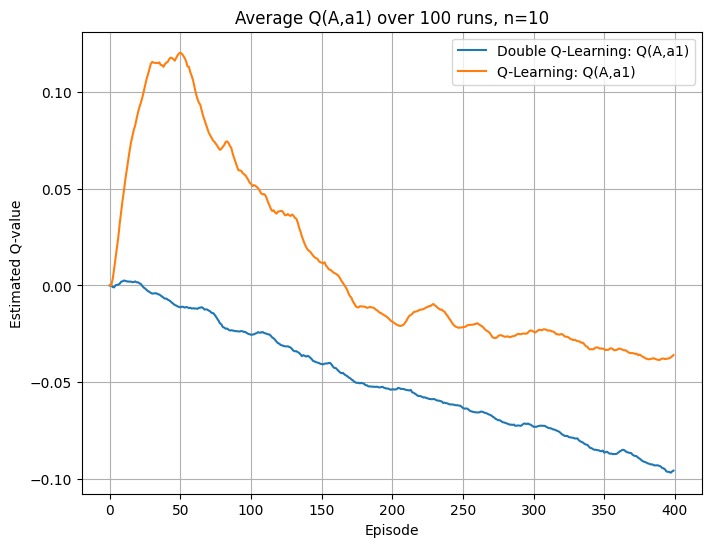

In [28]:
# -----------------------------------------------------------------------
# The MDP: States A,B and actions a1,a2,b1,...,bn (don't modify anything anymore, just run to get the graphs)
# -----------------------------------------------------------------------
@dataclass(frozen=True)
class P1State:
    """
    The MDP state, storing whether we are in "A" or "B".
    """
    name: str

class P1MDP(MarkovDecisionProcess[P1State, str]):
    
    def __init__(self, n: int):
        self.n = n

    def actions(self, state: NonTerminal[P1State]) -> Iterable[str]:
        """
        Return the actions available from this state.
          - if state is A => ["a1", "a2"]
          - if state is B => ["b1", ..., "bn"]
        """
        if state.state.name == "A":
            return ["a1", "a2"]
        else:
            return [f"b{i}" for i in range(1, self.n+1)]
    
    def step(
        self,
        state: NonTerminal[P1State],
        action: str
    ) -> Distribution[Tuple[State[P1State], float]]:
        """
        Return the distribution of (next state, reward) from (state, action):
          - A + a1 => reward 0, next state B
          - A + a2 => reward 0, next state terminal
          - B + b_i => reward ~ Normal(-0.1,1), next state terminal
        """
        if state.state.name == "A":
            if action == "a1":
                return Constant((NonTerminal(P1State("B")), 0.0))
            else:
                return Constant((Terminal(P1State("T")), 0.0))
        else:
            # For B + b_i => reward ~ N(-0.1,1), then terminal
            def sampler():
                r = np.random.normal(loc=-0.1, scale=1.0)
                return (Terminal(P1State("T")), r)
            return SampledDistribution(sampler)

def run_double_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Runs one 'chain' of Double Q-Learning for 'episodes' episodes,
    returning a list of Q-values for Q((A,a1)) at the end of each episode.
    """
    dq_iter = double_q_learning(mdp, start_dist, gamma)  # generator
    vals = []
    for _ in range(episodes):
        Q1 = next(dq_iter)
        # record Q1((A,a1)) each time
        qA1 = Q1((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def run_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Same but for standard Q-Learning
    """
    q_iter = q_learning(mdp, start_dist, gamma)
    vals = []
    for _ in range(episodes):
        Q = next(q_iter)
        qA1 = Q((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def main():
    # For reproducibility
    random.seed(0)
    np.random.seed(0)

    n = 10
    mdp = P1MDP(n)
    # Always start in A, as a NonTerminal
    start_dist = Constant(NonTerminal(P1State("A")))

    N_RUNS = 100
    N_EPISODES = 400

    all_dbl = []
    all_std = []

    for _ in range(N_RUNS):
        dbl_vals = run_double_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        std_vals = run_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        all_dbl.append(dbl_vals)
        all_std.append(std_vals)

    arr_dbl = np.array(all_dbl)
    arr_std = np.array(all_std)

    avg_dbl = np.mean(arr_dbl, axis=0)
    avg_std = np.mean(arr_std, axis=0)

    plt.figure(figsize=(8,6))
    plt.plot(avg_dbl, label='Double Q-Learning: Q(A,a1)')
    plt.plot(avg_std, label='Q-Learning: Q(A,a1)')
    plt.xlabel('Episode')
    plt.ylabel('Estimated Q-value')
    plt.title('Average Q(A,a1) over 100 runs, n=10')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

### 1. Compare the behavior of Q-Learning and Double Q-Learning.

Based on the provided plot, we observe a significant difference in the performance of the two algorithms:

* Q-Learning (Orange): There is a significant positive spike in the estimated value of $Q(A, a_1)$ during the first 100 episodes, reaching approximately **+0.12**. Since the true expected reward for reaching state $B$ and taking any action is **-0.1**, this indicates a severe **maximization bias** where the agent is consistently overestimating the value of the state.
* Double Q-Learning (Blue): Remains much more stable and keeps the estimate near zero or slightly negative throughout the training process. By successfully mitigating the overestimation "hump," it tracks the true expected value of the MDP much more accurately.

### 2. Explain why Q-Learning can exhibit maximization bias.

In this specific MDP, state $B$ has $n=10$ actions ($b_1, \dots, b_{10}$) with rewards drawn from a distribution with mean $-0.1$ and variance $1.0$. 

Due to high variance, in any given episode, at least one of these actions is likely to return a positive reward by pure chance. Because Q-Learning utilizes the maximum of these noisy estimates for its updates, it erroneously identifies these random positive outliers as the "best" path. 

This is a result of Jensen's Inequality, which states $E[\max(X_1, X_2, \dots, X_n)] \geq \max(E[X_1], E[X_2], \dots, E[X_n])$. In a stochastic environment, the expected value of the maximum is almost always greater than the maximum of the expected values, leading to systematic overestimation.



### 3. Discuss the advantages and possible drawbacks of Double Q-Learning in general MDPs.

Advantages: 
1. Since $Q_1$ and $Q_2$ are updated with different samples, the noise in action selection is decoupled from the noise in evaluation, resulting in unbiased estimates.
2. By not "chasing" random positive spikes, the agent's policy remains more stable and is less likely to converge prematurely to a sub-optimal action.
3. As shown in the graph, the values can and should go negative if the expected rewards are negative. Double Q-Learning reflects this environmental reality much faster than standard Q-Learning.

Disadvantages:
1. The requirement to store two complete Q-tables increases memory consumption. 
2. There is a slight increase in computational cost per update to manage two separate value approximations.
3. In deterministic environments where bias is not an issue, the convergence rate can be slower because updates are distributed between two tables, effectively reducing the learning frequency per table.